# Plotting for NAS-Bench-Suite Black-Box Optimizers

This notebook was used to plot the black-box optimizer experiments from Section 4 of 
[NAS-Bench-Suite: NAS Evaluation is (Now) Surprisingly Easy](https://arxiv.org/abs/2201.13396). This includes plotting the results of Random Search, Regularized Evolution, Local Search, BANANAS, and NPENAS.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [268]:
import sys
import os
import copy
import numpy as np
import json
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import kendalltau
matplotlib.rcParams['pdf.fonttype'] = 42

In [3]:
# method that gathers all of the results

# example result path:
# ~/results_nas_bench_suite/bbo_results_oct1/bbo_results_oct1_0/nasbench201/cifar100/npenas/config_28/7

# and the result dict structure:
# results_dict[28][nb201_c10][npenas] = [np.mean(values), np.std(values)]

def get_hpo_results(optimizers, search_spaces, root):
    errors = 0
    results_dict = {}
    root = os.path.expanduser(root)
    for seed_header in os.listdir(root):
        for search_space in search_spaces:
            search_space_dict = {}
            for optimizer in optimizers:
                optimizer_path = root + '/' + seed_header + '/' + file_dict[search_space] + '/' + optimizer
                if os.path.exists(optimizer_path):
                    for hpo_folder in os.listdir(optimizer_path):
                        hpo_seed = int(hpo_folder.split('_')[-1])
                        values = []
                        for seed in os.listdir(optimizer_path + '/' + hpo_folder):
                            result_path = optimizer_path + '/' + hpo_folder + '/' + seed + '/errors.json'
                            if os.path.isfile(result_path):
                                result = json.load(open(result_path))
                                valid_accs = result[1]['valid_acc']
                                value = np.max(valid_accs)
                                if not np.isnan(value):
                                    values.append(value)
                        if len(values) > 3:
                            # had to add these if statements because file structure is in a different order
                            if hpo_seed not in results_dict:
                                results_dict[hpo_seed] = {}
                            if search_space not in results_dict[hpo_seed]:
                                results_dict[hpo_seed][search_space] = {}
                            if optimizer not in results_dict[hpo_seed][search_space]:
                                results_dict[hpo_seed][search_space][optimizer] = {}
                            results_dict[hpo_seed][search_space][optimizer] = [np.mean(values), np.std(values)]
                        else:
                            print(len(values), 'not enough values', hpo_seed, search_space, optimizer)
                            errors += 1
                            if errors > 100:
                                print('ending early due to excess errors')
                                return results_dict

    return results_dict

In [56]:
# Define constants that will be used throughout the notebook

"""
Set up colors. There are 11 colors defined in 'defaults', and 3 markers/formats for the plot lines.
So there are 33 color/markers total.
"""
defaults = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            (1.0, 0.4980392156862745, 0.054901960784313725),
            (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
            (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
            (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
            (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
            (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
            (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
            (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
            (0.0, 0.0, 0.0)
           ]

fmts = ['-', '--', ':', '-.']
markers = ['^', 'v', 'o']
defaults = [np.array(d) for d in defaults]

color_dict={
    'rs':{'color':defaults[0], 'fmt':fmts[0]},
    're':{'color':defaults[1], 'fmt':fmts[0]},
    'ls':{'color':defaults[2], 'fmt':fmts[0]},
    'bananas':{'color':defaults[3], 'fmt':fmts[0]},
    'npenas':{'color':defaults[4], 'fmt':fmts[0]},
}

# how the optimizer names will be displayed in the plot legends:
pred_label_dict={
    'rs': 'Rand. Search', 're':'Reg. Evo.', 'ls':'Local Search', 
    'bananas':'BANANAS', 'npenas':'NPENAS'
}

In [232]:
# search space constants

# how the search space name will be displayed in the plot titles:
ss_dict_lined = {'nb101':'NB-101\n CIFAR10', 
                 'nb201_c10':'NB-201\n CIFAR10', 
                 'nb201_c100':'NB-201\n CIFAR100', 
                 'nb201_im':'NB-201\n ImageNet', 
                 'darts':'DARTS\n CIFAR10',
                 'nlp':'NB-NLP\n TreeBank',
                 'asr':'NB-ASR\n TIMIT',
                 'mr_3ddet':'NB-MR\n KITTI',
                 'mr_cls':'NB-MR\n ImageNet',
                 'mr_seg':'NB-MR\n City',
                 'mr_video':'NB-MR\n HMDB51',
                 'transmicro_obj':'TNB-Micro\n Object', 
                 'transmicro_scene':'TNB-Micro\n Scene', 
                 'transmicro_jigsaw':'TNB-Micro\n Jigsaw', 
                 'transmicro_room':'TNB-Micro\n Room',
                 'transmicro_segment':'TNB-Micro\n Semantic', 
                 'transmicro_normal':'TNB-Micro\n Surface', 
                 'transmicro_auto':'TNB-Micro\n Autoenc.', 
                 'transmacro_obj':'TNB-Macro\n Object', 
                 'transmacro_scene':'TNB-Macro\n Scene', 
                 'transmacro_jigsaw':'TNB-Macro\n Jigsaw', 
                 'transmacro_room':'TNB-Macro\n Room',
                 'transmacro_segment':'TNB-Macro\n Semantic', 
                 'transmacro_normal':'TNB-Macro\n Surface', 
                 'transmacro_auto':'TNB-Macro\n Autoenc.', 
          }

ss_dict_oneline = {'nb101':'NB-101 CIFAR10', 
                 'nb201_c10':'NB-201 CIFAR10', 
                 'nb201_c100':'NB-201 CIFAR100', 
                 'nb201_im':'NB-201 ImageNet', 
                 'darts':'DARTS CIFAR10',
                 'nlp':'NB-NLP TreeBank',
                 'asr':'NB-ASR TIMIT',
                 'mr_3ddet':'NB-MR KITTI',
                 'mr_cls':'NB-MR ImageNet',
                 'mr_seg':'NB-MR City',
                 'mr_video':'NB-MR HMDB51',
                 'transmicro_obj':'TNB-Micro Object', 
                 'transmicro_scene':'TNB-Micro Scene', 
                 'transmicro_jigsaw':'TNB-Micro Jigsaw', 
                 'transmicro_room':'TNB-Micro Room',
                 'transmicro_segment':'TNB-Micro Semantic', 
                 'transmicro_normal':'TNB-Micro Surface', 
                 'transmicro_auto':'TNB-Micro Autoenc.', 
                 'transmacro_obj':'TNB-Macro Object', 
                 'transmacro_scene':'TNB-Macro Scene', 
                 'transmacro_jigsaw':'TNB-Macro Jigsaw', 
                 'transmacro_room':'TNB-Macro Room',
                 'transmacro_segment':'TNB-Macro Semantic', 
                 'transmacro_normal':'TNB-Macro Surface', 
                 'transmacro_auto':'TNB-Macro Autoenc.', 
          }

# abbreviations used for the matrix plots:
ss_dict_mat = {'nb101':'NB-101', 
                 'nb201_c10':'NB-201', 
                 'nb201_c100':'NB-201', 
                 'nb201_im':'NB-201', 
                 'darts':'DARTS',
                 'nlp':'NB-NLP',
                 'asr':'NB-ASR',
                 'mr_3ddet':'NB-MR',
                 'mr_cls':'NB-MR',
                 'mr_seg':'NB-MR',
                 'mr_video':'NB-MR',
                 'transmicro_obj':'TNB-Micro', 
                 'transmicro_scene':'TNB-Micro', 
                 'transmicro_jigsaw':'TNB-Micro', 
                 'transmicro_room':'TNB-Micro',
                 'transmicro_segment':'TNB-Micro', 
                 'transmicro_normal':'TNB-Micro', 
                 'transmicro_auto':'TNB-Micro', 
                 'transmacro_obj':'TNB-Macro', 
                 'transmacro_scene':'TNB-Macro', 
                 'transmacro_jigsaw':'TNB-Macro', 
                 'transmacro_room':'TNB-Macro',
                 'transmacro_segment':'TNB-Macro', 
                 'transmacro_normal':'TNB-Macro', 
                 'transmacro_auto':'TNB-Macro', 
          }

# these are the file paths we used
file_dict = {
    'nb101':'nasbench101/cifar10', 
    'nb201_c10':'nasbench201/cifar10', 
    'nb201_c100':'nasbench201/cifar100', 
    'nb201_im':'nasbench201/ImageNet16-120', 
    'darts':'darts/cifar10', 
    'nlp':'nlp/LM-task', 
    'asr':'asr/TIMIT', 
    'transmicro_obj':'transbench101_micro/class_object',
    'transmicro_scene':'transbench101_micro/class_scene',
    'transmicro_jigsaw':'transbench101_micro/jigsaw',
    'transmicro_room':'transbench101_micro/room_layout',
    'transmicro_segment':'transbench101_micro/segmentsemantic',
    'transmicro_normal':'transbench101_micro/normal',
    'transmicro_auto':'transbench101_micro/autoencoder',
    'transmacro_obj':'transbench101_macro/class_object',
    'transmacro_scene':'transbench101_macro/class_scene',
    'transmacro_jigsaw':'transbench101_macro/jigsaw',
    'transmacro_room':'transbench101_macro/room_layout',
    'transmacro_segment':'transbench101_macro/segmentsemantic',
    'transmacro_normal':'transbench101_macro/normal',
    'transmacro_auto':'transbench101_macro/autoencoder',
    'mr_3ddet':'mr/3ddet',
    'mr_cls':'mr/cls',
    'mr_seg':'mr/seg',
    'mr_video':'mr/video',
            }

# Now load all of the data
 - Each algorithm is tagged as "algorithm_date"
 - The next cell will create a dictionary will all of the results from the specified search space

In [6]:
search_spaces = ['nb101', 'nb201_c10', 'nb201_c100', 'nb201_im', 'darts', 'asr', 'nlp',
                 'mr_3ddet', 'mr_cls', 'mr_seg', 'mr_video',
                 'transmicro_obj', 'transmicro_scene', 'transmicro_jigsaw', 
                 'transmicro_room', 'transmicro_segment', 'transmicro_normal', 
                 'transmicro_auto', 
                 'transmacro_obj', 'transmacro_scene', 'transmacro_jigsaw', 
                 'transmacro_room', 'transmacro_segment', 'transmacro_normal', 
                 'transmacro_auto']

optimizers=('rs', 're', 'ls', 'bananas', 'npenas')
root = '~/plotting_data/bbo'
results = get_hpo_results(optimizers, search_spaces, root=root)

# Now plot everything

In [435]:
result_folder = 'plots_nov10/'

# specify the seed that represents the default config:
default_config = 0

In [224]:
# plot default and hpo side by side
def plot_default_hpo(results, ss_group, optimizers, offset=0.1, scale_type='0-1', one_line=False, label=False, save=None):

    if not one_line:
        plot_width = .7 * len(ss_group)
    else:
        plot_width = .42 * len(ss_group)        
    fig, ax = plt.subplots(figsize=(plot_width,2))
    width = 0
    ss_order = []
    for search_space in ss_group:
        if one_line:
            ss_order.append(ss_dict_oneline[search_space])
        else:
            ss_order.append(ss_dict_lined[search_space])
        width += 1
        means = []
        for optimizer in optimizers:
            mean = results[default_config][search_space][optimizer][0]
            means.append(mean)

            hpo_means = []
            for hpo_seed in results.keys():
                if optimizer in results[hpo_seed][search_space]:
                    hpo_means.append(results[hpo_seed][search_space][optimizer][0])
            mean = np.max(hpo_means)
            means.append(mean)

        #print(search_space, means[::2])
        if scale_type == '0-1':
            min_acc, max_acc = np.min(means), np.max(means)
            means = [(m - min_acc) / (max_acc - min_acc) for m in means]

        i = 0
        for optimizer in optimizers:
            color = color_dict[optimizer]['color']
            
            # to average nbmr
            first, second = i, i+1
            if optimizer == 'rs' and 'mr' in search_space:
                second = i

            if width == 1:
                ax.scatter(width-offset, means[first], label=pred_label_dict[optimizer], color=color, marker='o')
                ax.scatter(width+offset, means[second], label=pred_label_dict[optimizer]+'+HPO', color=color, marker='x')
            else:
                ax.scatter(width-offset, means[first], color=color, marker='o')    
                ax.scatter(width+offset, means[second], color=color, marker='x')
            i += 2

    ax.set_xticks(range(1, len(ss_order)+1))
    if label:
        ax.set_xticklabels(ss_order, fontsize=12, rotation=90)
    else:
        ax.set_xticklabels(['' for _ in range(len(ss_order))], fontsize=12, rotation=90)

    if one_line:
        ax.legend(loc=(1.01,-.37))
    else:
        ax.legend(loc=(1.01,0))
    #ax.set_xlabel('NAS Benchmark Task', fontsize=14)    
    ax.set_ylabel('Scaled Accuracy', fontsize=12)   
    #ax.set_title('Scaled Accuracy of NAS Algorithms', fontsize=14)
    ax.set_title('NAS Algorithms', fontsize=14)
    
    if save:
        plt.savefig(result_folder + save, bbox_inches = 'tight', pad_inches = 0.1)

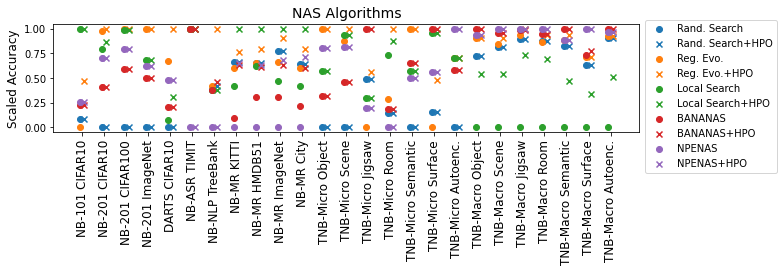

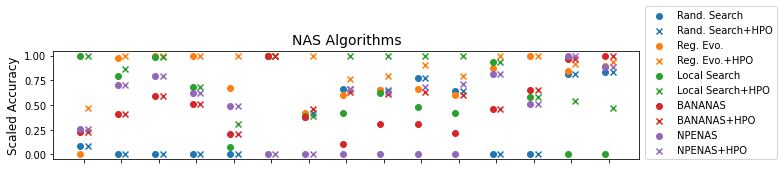

In [225]:
# plot the full results:
plot_default_hpo(results, search_spaces, optimizers, scale_type='0-1', one_line=True, label=True) #, save='optimizers_appendix.pdf')

# plot a representative subset:
ss_group = ['nb101', 'nb201_c10', 'nb201_c100', 'nb201_im', 'darts', 'asr', 'nlp', \
            'mr_3ddet', 'mr_video', 'mr_cls', 'mr_seg', \
            'transmicro_scene', 'transmicro_segment', 'transmacro_scene', 'transmacro_segment']
plot_default_hpo(results, ss_group, optimizers, scale_type='0-1', label=False) #, save='optimizers.pdf')

In [426]:
# compute the average ranks of the predictors, and the number of wins
# we give weight 1 to each search space, including the ones with multiple datasets (nb201, trans, mr)
# (correctly weighing each search_space,dataset pair makes the code a bit more complex)

def compute_ranks(results, optimizers):
    rank_results = []
    full_ranks_no_hpo = None
    full_ranks_hpo = None
    for hpo in [False, True]:
        ranks = np.zeros((len(search_spaces), len(optimizers)))
        nb201_indices = []
        trans_indices = []
        mr_indices = []
        for i, search_space in enumerate(results[default_config].keys()):
            values = []
            for optimizer in optimizers:
                if not hpo:
                    values.append(results[default_config][search_space][optimizer][0])
                else:
                    means = []
                    for hpo_seed in results.keys():
                        if optimizer in results[hpo_seed][search_space]:
                            means.append(results[hpo_seed][search_space][optimizer][0])
                    values.append(np.max(means))
            ranks[i] = np.flip(np.array(values).argsort()).argsort()
            if 'nb201' in search_space:
                nb201_indices.append(i)
            elif 'trans' in search_space:
                trans_indices.append(i)
            elif 'mr' in search_space:
                mr_indices.append(i)

        # compute num_wins
        num_wins = [0 for i in range(len(optimizers))]
        for i in range(len(ranks)):
            if i in nb201_indices:
                num_wins[np.argmin(ranks[i])] += 1/3
            elif i in trans_indices:
                num_wins[np.argmin(ranks[i])] += 1/14
            elif i in mr_indices:
                num_wins[np.argmin(ranks[i])] += 1/4
            else:
                num_wins[np.argmin(ranks[i])] += 1
                
        # scale by weight
        for i in nb201_indices[1:]:
            ranks[nb201_indices[0]] += ranks[i]
        ranks[nb201_indices[0]] /= 3
            
        for i in trans_indices[1:]:
            ranks[trans_indices[0]] += ranks[i]
        ranks[trans_indices[0]] /= 14
        
        for i in mr_indices[1:]:
            ranks[mr_indices[0]] += ranks[i]
        ranks[mr_indices[0]] /= 4

        indices_to_delete = [*nb201_indices[1:], *trans_indices[1:], *mr_indices[1:]]
        indices_to_delete.sort(reverse=True)

        for i in indices_to_delete:
            ranks = np.delete(ranks, i, axis=0)
                
        if not hpo:
            full_ranks_no_hpo = ranks
        else:
            full_ranks_hpo = ranks
        avg_ranks = np.mean(ranks, axis=0) + 1
        rank_results.append(avg_ranks)
        rank_results.append(num_wins)

    print("\t Avg. rank, default\t Num. #1's, default\t Avg. rank, HPO\t Num. #1's, HPO")
    for i, optimizer in enumerate(optimizers):
        if i == 3:
            print(optimizer, *[str(np.round(rank_results[j][i], 2))+'\t\t\t' for j in range(len(rank_results))])
        else:
            print(optimizer, '\t', *[str(np.round(rank_results[j][i], 2))+'\t\t\t' for j in range(len(rank_results))])

    for i, optimizer in enumerate(optimizers):
        print(pred_label_dict[optimizer], '&', *[str(np.round(rank_results[j][i], 2))+' &' for j in range(len(rank_results))])
    return full_ranks_no_hpo, full_ranks_hpo

In [427]:
full_ranks_no_hpo, full_ranks_hpo = compute_ranks(results, optimizers)

	 Avg. rank, default	 Num. #1's, default	 Avg. rank, HPO	 Num. #1's, HPO
rs 	 3.47			 0.75			 3.97			 0			
re 	 2.36			 3.39			 1.96			 3.29			
ls 	 2.66			 1.14			 2.41			 2.0			
bananas 3.02			 1.36			 3.17			 1.36			
npenas 	 3.48			 0.36			 3.49			 0.36			
Rand. Search & 3.47 & 0.75 & 3.97 & 0 &
Reg. Evo. & 2.36 & 3.39 & 1.96 & 3.29 &
Local Search & 2.66 & 1.14 & 2.41 & 2.0 &
BANANAS & 3.02 & 1.36 & 3.17 & 1.36 &
NPENAS & 3.48 & 0.36 & 3.49 & 0.36 &


In [446]:
# compute correlation between algo performance and {size, RWA}
algo_rankings = {
    'no_hpo':full_ranks_no_hpo,
    'hpo':full_ranks_hpo
}
# 101, 201, darts, asr, nlp, trans, mr
ss_rankings = {
    'ss_sizes':[432625, 6466, 1e18, 8242, 1e53, 3676, 1e23],
    'nbhd_sizes':[20.114, 24, 120, 21, 42, 15, 45.3],
}

for key1, ss_rank in ss_rankings.items():
    for i, optimizer in enumerate(optimizers):
        for key2, alg_rankings in algo_rankings.items():
        
            alg_rank = [ss[i] for ss in alg_rankings]
            value = kendalltau(alg_rank, ss_rank)[0]
            # print in readable format:
            print(value, key1, key2, optimizer)

for key1, ss_rank in ss_rankings.items():
    for key2, alg_rankings in algo_rankings.items():
        res = []
        for i, optimizer in enumerate(optimizers):       
            alg_rank = [ss[i] for ss in alg_rankings]
            value = kendalltau(alg_rank, ss_rank)[0]
            s = str(np.round(value, 2))
            if s[0] == '-':
                s = '-' + s[2:]
            else:
                s = s[1:]
            res.append(s + ' & ')
        
        # print in latex format:
        print(''.join(res))


-0.29277002188455997 ss_sizes no_hpo rs
-0.2646280620124816 ss_sizes hpo rs
-0.2057377999494559 ss_sizes no_hpo re
-0.2057377999494559 ss_sizes hpo re
-0.15018785229652765 ss_sizes no_hpo ls
-0.05006261743217588 ss_sizes hpo ls
0.47633051162246687 ss_sizes no_hpo bananas
0.2057377999494559 ss_sizes hpo bananas
0.2646280620124816 ss_sizes no_hpo npenas
0.3504383220252312 ss_sizes hpo npenas
-0.09759000729485331 nbhd_sizes no_hpo rs
-0.15877683720748895 nbhd_sizes hpo rs
-0.5143444998736397 nbhd_sizes no_hpo re
-0.3086066999241839 nbhd_sizes hpo re
0.2503130871608794 nbhd_sizes no_hpo ls
0.05006261743217588 nbhd_sizes hpo ls
0.3704792868174742 nbhd_sizes no_hpo bananas
0.3086066999241839 nbhd_sizes hpo bananas
0.15877683720748895 nbhd_sizes no_hpo npenas
0.05006261743217588 nbhd_sizes hpo npenas
-.29 & -.21 & -.15 & .48 & .26 & 
-.26 & -.21 & -.05 & .21 & .35 & 
-.1 & -.51 & .25 & .37 & .16 & 
-.16 & -.31 & .05 & .31 & .05 & 


In [433]:
"""
plot a matrix where entry [i,j] is the regret of a predictor 
tuned on search space i and evaluated on search space j.

Some of the matrix code is different types of scaling so that we can see the trends better.
"""
def replace_if_nan(num, replacement=0):
    if np.isnan(num) or np.isinf(num):
        return replacement
    return num

def compute_matrix(results, ss_group, optimizers, optimizer):

    # first, compute a list of all seeds that have full info
    hpo_seeds = []
    for hpo_seed in results.keys():
        valid = True
        for search_space in ss_group:
            for opt in optimizers:
                if not (search_space in results[hpo_seed] and \
                        opt in results[hpo_seed][search_space]):
                    valid = False
        if valid:
            hpo_seeds.append(hpo_seed)
        else:
            pass
    print('num valid', len(hpo_seeds))

    # now compute the raw results and best seed for each search space
    best_seeds = []
    raw_seed_results = np.zeros((len(ss_group), len(hpo_seeds)))
    scaled_seed_results = np.zeros((len(ss_group), len(hpo_seeds)))
    normed_seed_results = np.zeros((len(ss_group), len(hpo_seeds)))
    for i, search_space in enumerate(ss_group):
        raw_seed_results[i] = [results[hpo_seed][search_space][optimizer][0] for hpo_seed in hpo_seeds]
        best_seeds.append(np.argmax(raw_seed_results[i]))
        # 0-1 scaling:
        min_acc, max_acc = np.min(raw_seed_results[i]), np.max(raw_seed_results[i])
        scaled_seed_results[i] = [(m - min_acc) / (max_acc - min_acc) for m in raw_seed_results[i]]
        for j in range(len(scaled_seed_results[i])):
            scaled_seed_results[i][j] = replace_if_nan(scaled_seed_results[i][j], 0)

        # normalization:
        if optimizer != 'bananas':
            mean = np.mean(raw_seed_results[i])
            std = np.std(raw_seed_results[i])
            normed_seed_results[i] = [(m - mean) / (std) for m in raw_seed_results[i]]
        else:
            # todo: fix NaN errors when bananas is normalized
            normed_seed_results[i] = copy.deepcopy(raw_seed_results[i])

    # compute the matrices
    div_matrix = np.zeros((len(ss_group), len(ss_group)))
    kt_matrix = np.zeros((len(ss_group), len(ss_group)))
    scaled_matrix = np.zeros((len(ss_group), len(ss_group)))
    normed_matrix = np.zeros((len(ss_group), len(ss_group)))

    for i, ss_1 in enumerate(ss_group):
        for j, ss_2 in enumerate(ss_group):
            div_matrix[i][j] = scaled_seed_results[i][best_seeds[j]] / scaled_seed_results[i][best_seeds[i]]
            scaled_matrix[i][j] = scaled_seed_results[i][best_seeds[i]] - scaled_seed_results[i][best_seeds[j]]
            normed_matrix[i][j] = normed_seed_results[i][best_seeds[i]] - normed_seed_results[i][best_seeds[j]]
            kt_matrix[i][j] = replace_if_nan(kendalltau(scaled_seed_results[i], scaled_seed_results[j])[0], 0)

    return div_matrix, scaled_matrix, normed_matrix, kt_matrix, normed_seed_results

def scale_matrix(matrix, mean_div=2.5):
    # further scaling of the results
    # needs to happen in its own method so that an avg_matrix is input
    scaled_matrix = np.zeros((len(matrix), len(matrix)))
    maximum = np.max(matrix)
    mean = np.mean(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if mean_div > 0:
                scaled_matrix[i][j] = np.minimum(matrix[i][j], mean * mean_div)
            else:
                scaled_matrix[i][j] = np.maximum(matrix[i][j], mean / mean_div * -1)

    # 0-1 scale
    min_acc, max_acc = np.min(scaled_matrix), np.max(scaled_matrix)
    for i in range(len(scaled_matrix)):
        for j in range(len(scaled_matrix)):
            scaled_matrix[i][j] = (scaled_matrix[i][j] - min_acc) / (max_acc - min_acc) 

    return scaled_matrix

def plot_matrix(matrix, ss_group, save=None, cmap='viridis', hparam=False):
    coords = matrix
    cellsize = 5
    fig, ax = plt.subplots(1,1,figsize=(cellsize*1.2, cellsize*coords.shape[0]/coords.shape[1]))
    im = ax.pcolormesh(coords, edgecolor='k', linewidth=0.5, cmap=cmap) 
    if hparam:
        plt.title('HParam. Corr. for Black-Box Algorithms')
    else:
        plt.title('Generalizability for Black-Box Algorithms')
    plt.gca().invert_yaxis()
    ax.set_xticks([])
    ax.set_xticklabels('')
    ax.set_xticks([c+0.5 for c in range(coords.shape[0]-0)], minor=True)
    ax.set_xticklabels([ss_dict_mat[ss] for ss in ss_group], minor=True, rotation=90)
    ax.set_yticks([])
    ax.set_yticklabels('')    
    ax.set_yticks([c+0.5 for c in range(coords.shape[1]-0)], minor=True)
    ax.set_yticklabels([ss_dict_mat[ss] for ss in ss_group], minor=True)
    fig.colorbar(im, ax=ax)
    
    if save:
        plt.savefig(result_folder + save, bbox_inches = 'tight', pad_inches = 0.1)
        
    return matrix

num valid 100
num valid 100
num valid 100
num valid 100


/home/ubuntu/anaconda3/envs/mvenv/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/ubuntu/anaconda3/envs/mvenv/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


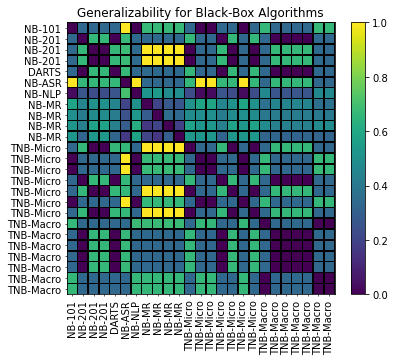

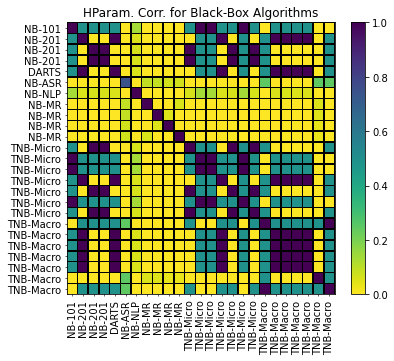

In [436]:
norm_matrices = []
kt_matrices = []
for i, optimizer in enumerate(('re', 'ls', 'npenas', 'bananas')):
    _, _, norm, kt_mat, _ = compute_matrix(results, search_spaces, optimizers, optimizer=optimizer)
    norm_matrices.append(norm)
    kt_matrices.append(kt_mat)

avg_norm_matrix = np.mean(np.array(norm_matrices), axis=0)
avg_kt_matrix = np.mean(np.array(kt_matrices), axis=0)

scaled_matrix = scale_matrix(avg_norm_matrix, mean_div=2.5)
scaled_kt_matrix = scale_matrix(avg_kt_matrix, mean_div=-1000000)

avg_scaled_matrix = plot_matrix(scaled_matrix, search_spaces, cmap='viridis') #, save='bbo_matrix_avg.pdf')
_ = plot_matrix(scaled_kt_matrix, search_spaces, cmap='viridis_r', hparam=True) #, save='bbo_corr_matrix.pdf')

In [350]:
def shorten_matrix(matrix):
    # this has hard-coded indices for groups of search_spaces
    if len(matrix) != 25:
        print('invalid matrix')
        return

    # compute a smaller matrix based on just ss_groups
    ss_idx_groups = [[0], [1,2,3], [4], [5], [6], [7,8,9,10], [i for i in range(11,25)]]
    ss_matrix = np.zeros((len(ss_idx_groups), len(ss_idx_groups)))
    for i, ss_1 in enumerate(ss_idx_groups):
        for j, ss_2 in enumerate(ss_idx_groups):
            ss_matrix[i][j] = np.mean(matrix[ss_1, :][:, ss_2])

    if False:
        # debug by looking at the matrix
        coords = ss_matrix
        cellsize = 5
        fig, ax = plt.subplots(1,1,figsize=(cellsize*1.2, cellsize*coords.shape[0]/coords.shape[1]))
        im = ax.pcolormesh(coords, edgecolor='k', linewidth=0.5) 
        plt.title('Generalizability for Predictors')
        plt.gca().invert_yaxis()
        fig.colorbar(im, ax=ax)
    return ss_matrix

def summarize_matrix(matrix):
    # compute the average transfer score
    to_avgs = []
    from_avgs = []
    adjustment = len(matrix) / (len(matrix) - 1)
    for i in range(len(matrix)):
        to_avgs.append(np.mean(matrix[i,:]) * adjustment)
        from_avgs.append(np.mean(matrix[:,i]) * adjustment)
    mean_avgs = np.mean([to_avgs, from_avgs], axis=0)
    to_avgs = np.round(to_avgs, 3)
    from_avgs = np.round(from_avgs, 3)
    mean_avgs = np.round(mean_avgs, 3)
    print(*[str(t) + ' &' for t in to_avgs])
    print(*[str(t) + ' &' for t in from_avgs])
    print(mean_avgs)  

In [444]:
shortened_matrix = shorten_matrix(avg_matrix)
print('summary of matrix (just 0-1 scaling)')
rounded = np.round(shortened_matrix, 2)

for row in rounded:
    print(*[str(i)[1:] + ' &' for i in row])
print()

summarize_matrix(shortened_matrix)

summary of matrix (just 0-1 scaling)
.0 & .25 & .25 & .0 & .25 & .75 & .27 &
.25 & .22 & .33 & .75 & .5 & .83 & .28 &
.25 & .33 & .0 & .75 & .5 & .5 & .23 &
.75 & .5 & .5 & .0 & .75 & .25 & .5 &
.07 & .28 & .28 & .73 & .0 & .64 & .28 &
.86 & .8 & .7 & .42 & .84 & .32 & .76 &
.27 & .28 & .23 & .73 & .48 & .7 & .28 &

0.461 & 0.528 & 0.428 & 0.542 & 0.381 & 0.784 & 0.495 &
0.407 & 0.444 & 0.383 & 0.731 & 0.555 & 0.666 & 0.433 &
[0.434 0.486 0.405 0.636 0.468 0.725 0.464]


In [178]:
# this is used to compare the best predictors on nb101 and nb201 vs best on every other search space
def compute_subsets(results, optimizers, ss_group, ss_indices_1, ss_indices_2):
    rank_results = []
    print(optimizers)
    for hpo in [False, True]:
        ranks = np.zeros((len(search_spaces), len(optimizers)))
        nb201_indices = []
        trans_indices = []
        mr_indices = []
        for i, search_space in enumerate(ss_group):
            values = []
            for optimizer in optimizers:
                if not hpo:
                    values.append(results[default_config][search_space][optimizer][0])
                else:
                    means = []
                    for hpo_seed in results.keys():
                        if optimizer in results[hpo_seed][search_space]:
                            means.append(results[hpo_seed][search_space][optimizer][0])
                    values.append(np.max(means))
            ranks[i] = np.flip(np.array(values).argsort()).argsort()
            if 'nb201' in search_space:
                nb201_indices.append(i)
            elif 'trans' in search_space:
                trans_indices.append(i)
            elif 'mr' in search_space:
                mr_indices.append(i)
                
        # scale by weight
        for i in nb201_indices[1:]:
            ranks[nb201_indices[0]] += ranks[i]
        ranks[nb201_indices[0]] /= 3
            
        for i in trans_indices[1:]:
            ranks[trans_indices[0]] += ranks[i]
        ranks[trans_indices[0]] /= 14
        
        for i in mr_indices[1:]:
            ranks[mr_indices[0]] += ranks[i]
        ranks[mr_indices[0]] /= 4

        indices_to_delete = [*nb201_indices[1:], *trans_indices[1:], *mr_indices[1:]]
        indices_to_delete.sort(reverse=True)

        for i in indices_to_delete:
            ranks = np.delete(ranks, i, axis=0)
               
        ranks_1, ranks_2 = [], []
        for i in range(len(ranks)):
            if i in ss_indices_1:
                ranks_1.append(ranks[i])
            elif i in ss_indices_2:
                ranks_2.append(ranks[i])
                
        avg_ranks = np.mean(ranks, axis=0) + 1
        avg_ranks_1 = np.mean(ranks_1, axis=0) + 1
        avg_ranks_2 = np.mean(ranks_2, axis=0) + 1
        
        avg_ranks_1 = [np.round(a, 2) for a in avg_ranks_1]
        avg_ranks_2 = [np.round(a, 2) for a in avg_ranks_2]
        avg_ranks = [np.round(a, 2) for a in avg_ranks]

        print('a:', *[str(a)+' &' for a in avg_ranks])
        print('1:', *[str(a)+' &' for a in avg_ranks_1])
        print('2:', *[str(a)+' &' for a in avg_ranks_2])
        
        rank_results.append(avg_ranks)

    print(rank_results)

In [231]:
full_ss = ['nb101', 
           'nb201_c10', 'nb201_c100', 'nb201_im',
           'darts', 
           'asr', 
           'nlp',
           'mr_cls', 'mr_3ddet', 'mr_seg', 'mr_video',
           'transmicro_obj', 'transmicro_scene', 'transmicro_jigsaw', 
           'transmicro_room', 'transmicro_segment', 'transmicro_normal', 
           'transmicro_auto', 'transmacro_obj', 'transmacro_scene', 'transmacro_jigsaw', 
           'transmacro_room', 'transmacro_segment', 'transmacro_normal', 
           'transmacro_auto']

ss_indices_1 = [0, 1]
ss_indices_2 = [2, 3, 4, 5, 6]

compute_subsets(results, optimizers, full_ss, ss_indices_1, ss_indices_2)

('rs', 're', 'ls', 'bananas', 'npenas')
a: 3.47 & 2.36 & 2.66 & 3.02 & 3.48 &
1: 4.5 & 3.0 & 1.5 & 3.5 & 2.5 &
2: 3.06 & 2.11 & 3.13 & 2.83 & 3.87 &
a: 3.97 & 1.96 & 2.41 & 3.17 & 3.49 &
1: 5.0 & 1.5 & 1.5 & 4.0 & 3.0 &
2: 3.56 & 2.14 & 2.77 & 2.84 & 3.69 &
[[3.47, 2.36, 2.66, 3.02, 3.48], [3.97, 1.96, 2.41, 3.17, 3.49]]
